Data Wrangling & Cleaning
---

This notebook includes the following steps:

1. Load the data from the 0 json
2. Fixes data types
3. Checks the data for reasonableness and 

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from bs4 import BeautifulSoup
from urllib.request import urlopen

import pickle

Step 1: Load up our scraped dataset
---

In [8]:
with open('../data/raw/0 - Scraped Games DF.pkl', 'rb') as file :
    games_df = pickle.load(file)

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   app_id                   50002 non-null  int64  
 1   title                    50002 non-null  object 
 2   release_date             49968 non-null  object 
 3   positive_review_percent  35269 non-null  float64
 4   number_of_reviews        35269 non-null  float64
 5   price                    49661 non-null  float64
 6   game_page_link           50002 non-null  object 
 7   tags                     50002 non-null  object 
 8   date_scraped             50002 non-null  object 
 9   developer                49990 non-null  object 
 10  publisher                49727 non-null  object 
 11  description              50002 non-null  object 
 12  interface_languages      50002 non-null  object 
 13  full_audio_languages     50002 non-null  object 
 14  subtitles_languages   

In [9]:
# I originally wanted to keep all unused language comment counts, but that makes the df exceed github's max file size.
# Boo-hoo!
# Let's just dump them here. They're the only ones fewer than 3k values.

cols_to_drop = []

for col in games_df.columns :
    if games_df[col].isnull().sum() > 20000 :
        cols_to_drop.append(col)

games_df = games_df.drop(columns=cols_to_drop)

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   app_id                   50002 non-null  int64  
 1   title                    50002 non-null  object 
 2   release_date             49968 non-null  object 
 3   positive_review_percent  35269 non-null  float64
 4   number_of_reviews        35269 non-null  float64
 5   price                    49661 non-null  float64
 6   game_page_link           50002 non-null  object 
 7   tags                     50002 non-null  object 
 8   date_scraped             50002 non-null  object 
 9   developer                49990 non-null  object 
 10  publisher                49727 non-null  object 
 11  description              50002 non-null  object 
 12  interface_languages      50002 non-null  object 
 13  full_audio_languages     50002 non-null  object 
 14  subtitles_languages   

Step 2: Standardize our data types
---

In [10]:
# The numbers in the comment count columns are strings
# with extra characters. Let's standardize them as ints.

# First, let's get a list of the columns that we need to process.
# That's all columns from the comments df and one column from the
# original game page scraped df.
%store -r top_10_languages
%store -r all_languages
relevant_langs = top_10_languages.copy()
relevant_langs.append('english')
%store relevant_langs


# We need all our comment counts to be ints.
# Some of them failed to scrape - we can almost certainly remove
# them without impacting our study, but I would like to check to
# make sure something didn't go wrong in our previous step that
# caused too many of them to fail.
# So, we'll two-birds this.
# As we ensure that all the values are ints, we'll remove the
# ones that are "Failed", and then display the removed indexes.
# We also have some games that weren't released at time of
# scraping, so we'll just remove those as well at this stage.
indexes_to_remove = set()

for index, row in games_df.iterrows() :
    for language in relevant_langs :
        # If the count is "Failed", mark it for deletion.
        if (row[language] == 'Failed') or (pd.isna(row[language])) :
            indexes_to_remove.add(index)
        
print(len(indexes_to_remove))

Stored 'relevant_langs' (list)
1530


In [11]:
# Not too bad. Let's just drop them, then integerize.

games_df = games_df.drop(indexes_to_remove)
games_df = games_df.reset_index(drop=True)

for language in relevant_langs :
    games_df[language] = games_df[language].astype(int)

In [12]:
# For games that have multiple publishers, developers, etc, they're all stored as one string.
# If we want to use this data eventually, we should split it into lists.
# Some games don't have publishers or developers, and that's fine.
# Oddly, some of them have trailing spaces.
for index, row in games_df.iterrows() :
    if not row['developer'] :
        games_df.at[index, 'developer'] = []
    else :
        if type(row['developer']) != list :
            row['developer'] = row['developer'].split(', ')
            # Since the above line changes the str into a list, we can .strip() each item in the list
            # with a comprehension.
            list_of_developers = [name.strip() for name in row['developer']]
            games_df.at[index, 'developer'] = list_of_developers

    # And again.
    if not row['publisher'] :
        games_df.at[index, 'publisher'] = []
    else :
        if type(row['publisher']) != list :
            row['publisher'] = row['publisher'].split(', ')
            list_of_publishers = [name.strip() for name in row['publisher']]
            games_df.at[index, 'publisher'] = list_of_publishers

In [13]:
# The tags are also just a string. We need them listed.
tags_list = []

for index, row in games_df.iterrows() :
    if (type(row['tags']) != list) & (row['tags'] != '') :
        tags_list = row['tags'].strip('[]').split(',')
        games_df.at[index, 'tags'] = tags_list

print(type(games_df.loc[0, 'tags']))

<class 'list'>


In [14]:
# Same problem for our languages types columns (interface, audio, subitles).

for index, row in games_df.iterrows() :
    if (type(row['interface_languages']) != list) & (row['interface_languages'] != '') :
        languages_list = row['interface_languages'].strip('[]').split(', ')
        games_df.at[index, 'interface_languages'] = languages_list
    if (type(row['full_audio_languages']) != list) & (row['full_audio_languages'] != '') :
        languages_list = row['full_audio_languages'].strip('[]').split(', ')
        games_df.at[index, 'full_audio_languages'] = languages_list
    if (type(row['subtitles_languages']) != list) & (row['subtitles_languages'] != '') :
        languages_list = row['subtitles_languages'].strip('[]').split(', ')
        games_df.at[index, 'subtitles_languages'] = languages_list

# Check.
print(type(games_df.loc[0, 'interface_languages']))

<class 'list'>


In [15]:
# For future reference, let's create a dictionary of tags codes & their meanings.
# We can get that from the search page.
# Keys will be the codes. Values will be the names.
url = 'https://store.steampowered.com/search'
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')

# The relevant data is in this one code block.
code_block = soup.find('div', id="TagFilter_Container")

# Create the empty dict.
tags_dict = {}

# Iterate over all 400+ tags described in the code block.
for listing in code_block.find_all('div', class_='tab_filter_control_row') :
    tag_code = listing.get('data-value')
    tag_name = listing.get('data-loc')
    tags_dict[tag_code] = tag_name

# We'll probably need it later, so let's save it a couple ways.
# Weirdly, it's quicker and easier to do this via a DF.
tags_dict_df = pd.DataFrame.from_dict(tags_dict, orient='index')
tags_dict_df.to_csv('../data/raw/tag_dictionary.csv')
%store tags_dict

Stored 'tags_dict' (dict)


In [16]:
# For standardization, let's convert the numeric tags to text tags now.

for index, row in games_df.iterrows() :
    if row['tags'] != ['Failed'] :
        tag_container = []
        for tag in row['tags'] :
            tag_container.append(tags_dict[tag])
        games_df.at[index, 'tags'] = tag_container.copy()

Implement indicator variables
---

In [17]:
# For language_types, implement pipes (???)
# NOTE:dx WHAT DID I MEAN BY THIS??????

Step 3: Sanity checks
---

<Axes: >

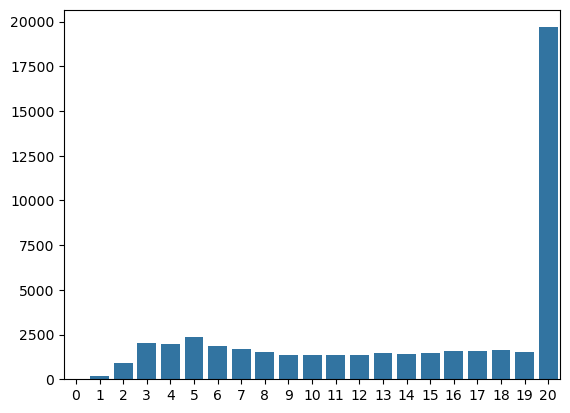

In [18]:
# Since our tag_list column is very important to us, let's make sure
# that the entries are reasonably comparable.

# In order to count the number of tags in each game's tag list,
# let's turn that column into a list of lists (by way of a series)
# so that we can use a list comprehension to get a list of len()s.
series_of_tags_column_values = games_df['tag_list']
list_of_tags_column_values = series_of_tags_column_values.tolist()
tags_values_lengths = [len(x) for x in list_of_tags_column_values]

# Now we organize the counts into a dictionary, where the keys are
# the lengths and the values are the frequencies of those lengths.
dict_of_lenghts = {}

for length in tags_values_lengths :
    if length in dict_of_lenghts :
        dict_of_lenghts[length] += 1
    else :
        dict_of_lenghts[length] = 1

# Now let's plot it.
lengths = []
for key, value in dict_of_lenghts.items() :
    lengths.append((key, value))

x_axis = [x[0] for x in lengths]
y_axis = [x[1] for x in lengths]

sns.barplot(x=x_axis, y=y_axis)

# Looks not too bad. Looks like the vast majority of games have 20 tags.

In [19]:
# I discovered that summing the number of comments in the top 10 loc languages + En
# as recorded in our DF resulted in a HIGHER comment count than Steam displays (which
# is the one we grabbed from Steam as "number_of_reviews").

# I don't know why that is, but it doesn't really matter. What we want is the RELATIVE
# difference in comments per game WITHIN each language, so as long as Steam calculates
# the number of comments in each language in a consistent way WITHIN each language, our
# method still works.

# Thus the "number_of_reviews" column may be useless to us, BUT I'm loathe to let go
# of any data. Let's keep it for now, and just add a new column that we'll use for our
# calculations: "relevant_langs_review_sum"

games_df['relevant_langs_comments_sum'] = None

for index, row in games_df.iterrows() :
    games_df.loc[index, 'relevant_langs_comments_sum'] = row[relevant_langs].sum()

games_df['relevant_langs_comments_sum'] = games_df['relevant_langs_comments_sum'].astype(int)

In [20]:
# NOTE: This NLP step is pretty complex and not entirely relevant for the ML task at hand, so we'll leave it out for now.





# # Check for string similarity in all verbal cols.
# # In developer and publisher, this could likely find typos.

# # First, let's create sets of all the extant developer and publisher names
# # as currently typed.

# set_of_developer_names = set()

# for developers_list in games_df['developer'] :
#     for developer in developers_list :
#         set_of_developer_names.add(developer)

# set_of_publisher_names = set()

# for publishers_list in games_df['publisher'] :
#     for publisher in publishers_list :
#         set_of_publisher_names.add(publisher)

# # Now, let's see if any items in that list are super similar to each other.
# # This could possibly the the result of a typo.
# # Let's first find the MOST similar pair in each set.
# # If these pairs are clearly not typos, then it's very likely that there are
# # no typos at all.

# list_of_developer_similarities = []
# listing = []

# for developer in set_of_developer_names :
#     # Create a set of names to test this name against.
#     # We want to avoid testing the name against itself,
#     # since that will return a maximum similarity score
#     # and make our lives harder.
#     # So, we'll create a new set, then drop this name
#     # from the set before doing the comparisons.
#     testing_set = set_of_developer_names.copy()
#     testing_set.remove(developer)
#     highest = process.extract(developer, testing_set, limit=1)
#     # We need to retain both of the tested strings, while .extract only
#     # returns the second one. We'll have to group them manually.
#     # Let's also arbitrarily set 90 as the cutoff for similarity.
#     if highest[0][1] >= 90 :
#         listing = [developer, highest[0][0], highest[0][1]]
#         list_of_developer_similarities.append(listing)


# # Then we do it all again for publishers.
# list_of_publisher_similarities = []

# for publisher in set_of_publisher_names :
#     testing_set = set_of_publisher_names.copy()
#     testing_set.remove(publisher)
#     highest = process.extract(publisher, testing_set, limit=1)
#     if highest[0][1] >= 90 :
#         listing = [publisher, highest[0][0], highest[0][1]]
#         list_of_publisher_similarities.append(listing)


# # Now we sort the lists by the similarity score.
# list_of_developer_similarities.sort(key=lambda x: x[2], reverse=True)
# list_of_publisher_similarities.sort(key=lambda x: x[2], reverse=True)


# # Let's take a look at some of them... and also get a feel for
# # how long these lists are (and therefore how many of these names
# # are truly similar).
# print('Similar developer names:')
# print(list_of_developer_similarities[0:10])
# print('Total similarity scores over 90: '+str(len(list_of_developer_similarities)))
# print('')
# print('Similar publisher names:')
# print(list_of_publisher_similarities[0:10])
# print('Total similarity scores over 90: '+str(len(list_of_publisher_similarities)))

# # Well, what I've learned from this is that the names of developers and publishers
# # would be a LOT of work to fix. Since we don't need them for now (they aren't part
# # of our key analysis), we can just leave them as-is and clean them later if we need
# # them.

Step 4: Determine completeness
---

In [21]:
# While I want to keep all the data around just in case, this is a great
# point for us to determine whether some rows may not be useful for us.

# Our main label is the comment counts per language, so we can safely drop
# all rows that have no language-specific comment counts at all.

indexes_to_drop = []

for index, row in games_df[relevant_langs].iterrows() :
    if row.sum() == 0 :
        indexes_to_drop.append(index)

print(len(indexes_to_drop))


152


In [22]:
# Not bad. Not worth fussing over. Let's just throw them out
# directly.
games_df = games_df.drop(indexes_to_drop)
games_df = games_df.reset_index(drop=True)

In [23]:
# Our main feature is the tags, so we should make sure that all rows have them.
# We can use the 'tags' col for this, since a presence in the 'tags' column
# implies presence in the 'tag_list' column as well.
indexes_to_drop = []

for index, row in games_df.iterrows() :
    if len(row['tags']) == 0 :
        indexes_to_drop.append(index)

print(len(indexes_to_drop))
# Excellent! Looks like we're in the clear there.

0


Step 5: A bit more standardization
---

In [24]:
# I've noticed that the way languages are written in the langauge types columns is different
# from the way they're written in the languages columns. We'll need them to match up if we
# want to do a comparative analysis.

# The problems are threefold.
# First, the capitalization is different.
# Second, the language types columns split up some languages (for example, Spanish is split
#   into "Spanish - Spain" and "Spanish - Latin America").
# Third, some are just spelled differently, like "schinese" and "Simplified Chinese".

# Since I don't want to lose data, I'll make new columns to hold the 'reduced' versions
# (for example, where 'Spanish- Spain' is 'reduced' to 'spanish')

# First, make cols and fill 'em with lists
games_df['mod_interface_languages'] = [[] for _ in range(len(games_df))]
games_df['mod_full_audio_languages'] = [[] for _ in range(len(games_df))]
games_df['mod_subtitles_languages'] = [[] for _ in range(len(games_df))]


# Next, let's just lowcap everything. Turn down the volume a bit.
for index, row in games_df.iterrows() :

    for item in row['interface_languages'] :
        # Make a easy-to-mess-with version
        lang = item.lower()

        # Check to see if it's a variant, replace if so
        for language in relevant_langs :
            if language in lang :
                lang = language

        # And it looks like there are three special cases we need to handle specifically.
        if lang == 'simplified chinese' :
            lang = 'schinese'
        
        if lang == 'portuguese - brazil' :
            lang = 'brazilian'
        
        if lang == 'korean' :
            lang = 'koreana'

        # Add the lowercaseified, standardizified version to the col in the main df
        games_df.loc[index, 'mod_interface_languages'].append(lang)


    # Now we do the same for the other two langauge type columns...
    for item in row['full_audio_languages'] :
        # Make a easy-to-mess-with version
        lang = item.lower()

        # Check to see if it's a variant, replace if so
        for language in relevant_langs :
            if language in lang :
                lang = language

        # And it looks like there are two special cases we need to handle specifically.
        if lang == 'simplified chinese' :
            lang = 'schinese'
        
        if lang == 'portuguese - brazil' :
            lang = 'brazilian'

        if lang == 'korean' :
            lang = 'koreana'

        # Add the lowercaseified, standardizified version to the col in the main df
        games_df.loc[index, 'mod_full_audio_languages'].append(lang)


    for item in row['subtitles_languages'] :
        # Make a easy-to-mess-with version
        lang = item.lower()

        # Check to see if it's a variant, replace if so
        for language in relevant_langs :
            if language in lang :
                lang = language

        # And it looks like there are two special cases we need to handle specifically.
        if lang == 'simplified chinese' :
            lang = 'schinese'
        
        if lang == 'portuguese - brazil' :
            lang = 'brazilian'

        if lang == 'korean' :
            lang = 'koreana'

        # Add the lowercaseified, standardizified version to the col in the main df
        games_df.loc[index, 'mod_subtitles_languages'].append(lang)

Step 6: Wrangle a couple more key columns
---

In [25]:
# Let's look at how our prices are distributed...
list_of_prices = games_df['price']
counts = list_of_prices.value_counts()
print(counts[counts > 50])
print(counts[counts > 50].sum())

0.0       6907
499.0     5493
999.0     5109
99.0      4667
199.0     3387
299.0     3055
1999.0    2683
1499.0    2613
399.0     2088
699.0     1709
599.0     1575
799.0     1366
2999.0     912
2499.0     842
1199.0     697
1299.0     697
899.0      694
3999.0     463
1099.0     342
1399.0     272
1799.0     246
5999.0     215
1599.0     199
1699.0     176
4999.0     174
3499.0     131
1899.0     113
4499.0      68
Name: price, dtype: int64
46893


In [26]:
# We can see that almost 5/6 of our games fall into just a
# few price points! That's significant to know. Let's use
# these as bins, then "below that" and "above that" as
# separate bins, for a total of 13 bins.

# I'm not 100% confident in the efficacy of this method,
# so let's preserve the original price data in the DF.
# Later, when modeling, we can see if there's a reason
# to use one or the other.

ranges = [-5, 0, 700, 1200, 1700, 2200, 2700, 3200, 3700, 4200, 4700, 5200, 5700, 6500, 7500, np.inf]
range_names = ['none', 'under 10', '999', '1499', '1999', '2499', '2999', '3499', '3999', '4499', '4999', '5499', '5999', '6999', 'over 80']
games_df['price_category'] = pd.cut(games_df['price'], bins=ranges, labels=range_names)

In [27]:
# We have all the info we need now, but it's not quite in a form
# that we can use. The total number of comments per language is
# meaningless - we need to know the average proportion of comments in
# that language, so we can tell if any individual game (and therefore
# any specific combination of tags) generates more engagement in that
# market than others do.

# Unfortunately, there's one other thing that probably impacts the
# proportion of comments much more than the game itself - whether or
# not the game has been localized into that language at all. So we can
# control for that, making multiple constants...

# To find the average, we'll need the total amount of comments in all langs
# for all games.
total_comments = games_df['relevant_langs_comments_sum'].sum()

# Now we can programmatically calculate the percentage of ALL comments
# that each language occupies.
language_averages_agnostic = {}

# Iterate over the languages, summing all comments in that language to find
# the overall average.
for language in relevant_langs :
    total_comments_l = games_df[language].sum()
    language_average = total_comments_l / total_comments
    language_averages_agnostic[language] = language_average

print(language_averages_agnostic)


{'german': 0.3525690379410166, 'french': 0.016535154356537875, 'spanish': 0.03161420282480964, 'brazilian': 0.030713682223319053, 'russian': 0.08821763768630837, 'italian': 0.004822618716897914, 'schinese': 0.10997778832079974, 'japanese': 0.0038003839991883103, 'koreana': 0.014845543508421526, 'polish': 0.018375030031172118, 'english': 0.3285289203915288}


In [28]:
# Above is the calculation if we ignore whether or not the game is even in that
# language. Let's see if it's much different when we take into account text, voice,
# and subtitle translation, or any of the three.

# Let's subset for these 4 situations, then run the same calculations again.

language_averages_any = {}
language_averages_interface = {}
language_averages_audio = {}
language_averages_subtitles = {}


# Do it for all languages, all situations.
for language in relevant_langs :

    # First, the condition of the target language being localized in any way.
    running_language_comments = 0
    running_total_comments = 0

    for index, row in games_df.iterrows() :
        if language in row['mod_interface_languages'] or language in row['mod_full_audio_languages'] or language in row['mod_subtitles_languages'] :
            if not pd.isna(row[language]) :
                running_language_comments += int(row[language])
            if not pd.isna(row['relevant_langs_comments_sum']) :
                running_total_comments += row['relevant_langs_comments_sum']
    if running_total_comments != 0 :
        language_averages_any[language] = running_language_comments / running_total_comments


    # Now, the condition of the target language being an interface language.
    running_total_comments = 0
    running_language_comments = 0

    for index, row in games_df.iterrows() :
        if language in row['mod_interface_languages'] :
            if not pd.isna(row[language]) :
                running_language_comments += row[language]
            if not pd.isna(row['relevant_langs_comments_sum']) :
                running_total_comments += row['relevant_langs_comments_sum']
        if running_total_comments != 0 :
            language_averages_interface[language] = running_language_comments / running_total_comments


    # Now, the condition of the target language being an audio langauge.
    running_total_comments = 0
    running_language_comments = 0

    for index, row in games_df.iterrows() :
        if language in row['mod_full_audio_languages'] :
            if not pd.isna(row[language]) :
                running_language_comments += row[language]
            if not pd.isna(row['relevant_langs_comments_sum']) :
                running_total_comments += row['relevant_langs_comments_sum']
    if running_total_comments != 0 :
        language_averages_audio[language] = running_language_comments / running_total_comments


    # Now, the condition of the target language being a subtitle langauge.
    running_total_comments = 0
    running_language_comments = 0

    for index, row in games_df.iterrows() :
        if language in row['mod_subtitles_languages'] :
            if not pd.isna(row[language]) :
                running_language_comments += row[language]
            if not pd.isna(row['relevant_langs_comments_sum']) :
                running_total_comments += row['relevant_langs_comments_sum']
    if running_total_comments != 0 :
        language_averages_subtitles[language] = running_language_comments / running_total_comments

In [29]:
print(language_averages_agnostic)
print(language_averages_any)
print(language_averages_interface)
print(language_averages_audio)
print(language_averages_subtitles)

{'german': 0.3525690379410166, 'french': 0.016535154356537875, 'spanish': 0.03161420282480964, 'brazilian': 0.030713682223319053, 'russian': 0.08821763768630837, 'italian': 0.004822618716897914, 'schinese': 0.10997778832079974, 'japanese': 0.0038003839991883103, 'koreana': 0.014845543508421526, 'polish': 0.018375030031172118, 'english': 0.3285289203915288}
{'german': 0.3492516482136332, 'french': 0.017623536582639456, 'spanish': 0.03320930777612948, 'brazilian': 0.03383091045070804, 'russian': 0.09975575661225837, 'italian': 0.005199840927033082, 'schinese': 0.13508260014683035, 'japanese': 0.0039495237689310654, 'koreana': 0.017967641724577564, 'polish': 0.021762775271549968, 'english': 0.3285289203915288}
{'german': 0.34920586526794267, 'french': 0.01762877510640206, 'spanish': 0.033210634593159066, 'brazilian': 0.033806689998559625, 'russian': 0.09976857004136931, 'italian': 0.0051999269741517685, 'schinese': 0.1351647107222475, 'japanese': 0.003951442481758586, 'koreana': 0.0179715

In [30]:
# I'm not sure if this is "wrangling"  or "feature engineering," but I might as well
# end this section with a full dataset...

# Let's create a column with the DIFFERENCES between the %s of comments in a language
# on a certain game and the average number of comments in that language on all games.
# A positive number here will indicate above-average interest within this language
# group for this game, and a negative number will indicate below-average interest.

# We'll make 5 such columns, one for each of the "language_averages" metrics. Later,
# during EDA, we can see which (if any) of them yield a clearer result.

# Since we have what we need already, let's just dig right in to creating columns.
# Let's make one column for each metric, and store all language values in a dict
# for each game in that column.

holding_dict = {}

games_df['comment_ratios'] = ''
games_df['comment_diff_agnostic'] = ''
games_df['comment_diff_any'] = ''
games_df['comment_diff_interface'] = ''
games_df['comment_diff_audio'] = ''
games_df['comment_diff_subtitles'] = ''


# First we need to create the dict of the ratio of comments for that specific
# language/game pair.
for index, row in games_df.iterrows() :

    for language in relevant_langs :
        score = np.nan
        score = row[language] / row['relevant_langs_comments_sum']
        holding_dict[language] = score
    games_df.at[index, 'comment_ratios'] = holding_dict 
    holding_dict={}

# Now that that column is filled in, we can populate the rest of them with calculations.
for index, row in games_df.iterrows() :

    # Start with the agnostic metric.
    for language in relevant_langs :
        score = np.nan
        score = row['comment_ratios'][language] - language_averages_agnostic[language]
        holding_dict[language] = score
    games_df.at[index, 'comment_diff_agnostic'] = holding_dict.copy()
    holding_dict={}

    # Now we do the 'any' metric
    for language in relevant_langs :
        score = np.nan
        if language in row['mod_interface_languages'] or \
                language in row['mod_full_audio_languages'] or \
                language in row['mod_subtitles_languages'] :
            score = row['comment_ratios'][language] - language_averages_any[language]
        holding_dict[language] = score
    games_df.at[index, 'comment_diff_any'] = holding_dict.copy()
    holding_dict={}

    # "interface_languages" metric.
    for language in relevant_langs :
        score = np.nan
        if language in row['mod_interface_languages'] :
            score = row['comment_ratios'][language] - language_averages_interface[language]
        holding_dict[language] = score
    games_df.at[index, 'comment_diff_interface'] = holding_dict.copy()
    holding_dict={}

    # "full_audio" metric.
    for language in relevant_langs :
        score = np.nan
        if language in row['mod_full_audio_languages'] :
            score = row['comment_ratios'][language] - language_averages_audio[language]
        holding_dict[language] = score
    games_df.at[index, 'comment_diff_audio'] = holding_dict.copy()
    holding_dict={}

    # Last but not least, 'subtitles.'
    for language in relevant_langs :
        score = np.nan
        if language in row['mod_subtitles_languages'] :
            score = row['comment_ratios'][language] - language_averages_subtitles[language]
        holding_dict[language] = score
    games_df.at[index, 'comment_diff_subtitles'] = holding_dict.copy()

In [31]:
# Now that all our ratios are in dictionary form, it feels kind of silly for the
# comment counts to have their own columns. Let's dictify that one as well.

games_df['language_comment_counts'] = ''

for index, row in games_df.iterrows() :
    holding_dict = {}
    for language in relevant_langs :
        holding_dict[language] = row[language]
    games_df.at[index, 'language_comment_counts'] = holding_dict.copy()

Step 6: Save and Quit
---
We now have the maximum amount of data that we will produce before modeling.

In the next notebook, we will pare down the columns and perform other steps to prepare for modeling.

We'll also save some of the variables we need along the way.

In [34]:
# First, let's reorder or coulmns to a more sane order.
new_column_order = ['app_id', 'title', 'developer', 'publisher', 'description', 'release_date', 'price', \
                    'price_category', 'number_of_reviews', 'positive_review_percent', 'relevant_langs_comments_sum', \
                    'tags', 'tag_list', 'interface_languages', 'mod_interface_languages', 'full_audio_languages', \
                    'mod_full_audio_languages', 'subtitles_languages', 'mod_subtitles_languages', \
                    'language_comment_counts', 'comment_ratios', 'comment_diff_agnostic', 'comment_diff_any', \
                    'comment_diff_interface', 'comment_diff_audio', 'comment_diff_subtitles', 'game_page_link', 'date_scraped']

# Do it
games_df = games_df.reindex(columns=new_column_order)

# We'll also drop some data that I wish we could keep into the preprocessing stage, just because GitHub
# doesn't like my file sizes.
columns_to_drop = ['title', 'game_page_link', 'developer', 'publisher', \
                   'description', "number_of_reviews", "interface_languages", "full_audio_languages", \
                    "subtitles_languages"]

games_df = games_df.drop(columns=columns_to_drop)

# Check it
games_df.columns

Index(['app_id', 'release_date', 'price', 'price_category',
       'positive_review_percent', 'relevant_langs_comments_sum', 'tags',
       'tag_list', 'mod_interface_languages', 'mod_full_audio_languages',
       'mod_subtitles_languages', 'language_comment_counts', 'comment_ratios',
       'comment_diff_agnostic', 'comment_diff_any', 'comment_diff_interface',
       'comment_diff_audio', 'comment_diff_subtitles', 'date_scraped'],
      dtype='object')

In [35]:
with open('../data/interim/1 - Games DF - Wrangled', 'wb') as file :
    pickle.dump(games_df, file)

%store all_languages

Stored 'all_languages' (list)


---------------------------